#  Image Captioning - CNN encoding-->Attention-->LSTM decoding

# Loading all the dependencies

In [2]:
# try:
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
print(tf.__version__)


# !pip install opencv-python
import cv2

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
import string
from numpy import array
from pickle import load
import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
# from keras.backend.tensorflow_backend import set_session

import tensorflow as tf
import datetime
warnings.filterwarnings("ignore")
import re
from tensorflow.python.keras.backend import set_session
import keras
import sys, time, os, warnings 
from pickle import dump

from collections import Counter
from tqdm import tqdm
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.layers import LSTM
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2.4.1


In [6]:
# !cd /ssd_scratch/cvit/ 
# !mkdir starc52 
# !cd /home/starc52
# !scp -r starc52@ada:/share1/dataset/Flickr-8K/ starc52@gnode30:/ssd_scratch/cvit/starc52/
# !cd /ssd_scratch/cvit/starc52/Flickr-8K
# !tar -xf Flickr-8K.tar
# !cd /home/starc52/

# Utility Functions to load and clean data

In [7]:
def load_doc(filename):
    
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    return text

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return (text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        word_length = len(word)
        
        if word_length<=1:
            continue
        else:
            text_len_more_than1 += " " + word            
            
    return (text_len_more_than1)

def remove_numeric(text, printTF=False):
    text_no_numeric = ""
    for word in text.split():
        if printTF:
            print("    {:10} : {:}".format(word, word.isalpha()))
        if word.isalpha():
            text_no_numeric += " " + word
    return (text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

# Exploratory Data Analysis(EDA)

In [8]:
from os import listdir

descriptions_dir = "/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flickr8k.token.txt"

image_dir = "/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/"
images = listdir(image_dir)

print("The number of jpg flies in Flicker8k: {}".format(len(images)))

The number of jpg flies in Flicker8k: 16182


# Making a dataframe out of raw text


In [10]:
count = 0

caption_file = "/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flickr8k.token.txt"
text = load_doc(caption_file)
print(len(text.split('\n')))

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        count+=1
        continue
    w = col[0].split('#')
    tmp = col[1].lower()
    datatxt.append(w + [tmp])

print(datatxt, count)
data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])

uni_filenames = np.unique(data.filename.values)

data.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



index                   filename  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     3  1000268201_693b08cb0e.jpg   
4     4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [11]:
## Marking files as invalid if not having .jpg extension

def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if not (found):
        print("Error file: {}".format(filenames))

In [12]:
invalid_filename_check(data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [13]:
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data.shape

(40455, 3)

# Let's explore the dataframe

In [14]:
unique_filenames = np.unique(data.filename.values)

#  [3] Preprocessing




In [18]:
def create_vocabulary(data):
  caption_vals = data.caption.values  
  vocab = []

  for captions in caption_vals:
    caption = captions.split()
    vocab.extend(caption)
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [19]:
vocabulary = create_vocabulary(data)

Vocabulary Size : 8918


### [3.2] Captions

In [20]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    keys = ct.keys()
    appen_1 = []
    
    for i in keys:
        appen_1.append(i)

    values = ct.values()
    appen_2 = []
        
    for j in values:
        appen_2.append(j)
    
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [21]:
dfwordcount = df_word_count(data,vocabulary)

## The most and least frequently appearing words


In [24]:
caption_vals = data.caption.values

for i, caption in enumerate(caption_vals):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [25]:
clean_vocabulary = create_vocabulary(data)

Vocabulary Size : 8357


In [27]:
data_file = data["filename"]  
all_img_name_vector = []

for filenames in data_file:
    all_img_name_vector.append(os.path.join(image_dir, filenames))

all_img_name_vector[:10]

['/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

## Preprocessing the captions (adding '< start >' and '< end >' tags to every caption), so that out ML model understands the starting and ending of each caption.

In [28]:
total_captions = []

caption_data = data["caption"].astype(str)

for caption  in caption_data:
    total_captions.append('<start> ' + caption+ ' <end>')

total_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [32]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


In [33]:
def data_limiter(num,total_captions,all_img_name_vector):
    
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  return train_captions[:num], img_name_vector[:num]

In [34]:
train_captions,img_name_vector = data_limiter(150000,total_captions,all_img_name_vector)

In [35]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40455 , Total images = 40455


## Save variables in a pickle file and restore them to use it again

In [36]:
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [37]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [38]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40455 , Total images = 40455


## Need to bring every image of shape (224,224,3) as we have used VGG-16

## Creating functions and trying Image Augmentation

In [43]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)



## Resizing of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


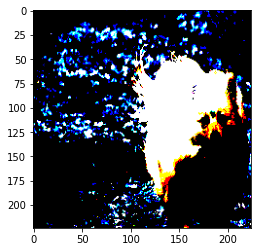

In [44]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img_name = os.path.join(image_dir, "3439243433_d5f3508612.jpg")
img1, img1_path = load_image(img_name)
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [48]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
image_features_extract_model = tf.keras.Model(image_model.input, image_model.layers[-1].output)

In [49]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Features extractraction from VGG16

 


In [50]:
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

['/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1003163366_44323f5815.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1007129816_e794419615.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1007320043_627395c3d8.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1009434119_febe49276a.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1012212859_01547e3f17.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1015118661_980735411b.jpg', '/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


## Map each image name to the function to load the image 

In [52]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

## After this step all the images have been resized to (224,224,3)

In [55]:
# for img, path in tqdm(image_dataset):
    
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
#     for bf, p in zip(batch_features, path):
        
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

In [56]:
np_img = np.load(os.path.join(image_dir, "3338291921_fe7ae0c8f8.jpg.npy"))

## Tokenizing the captions and creating vocabulary

In [58]:
def tokenize_caption(top_k,train_captions):

  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

### MaxLength and MinLength of any captions

In [64]:
def calc_length(tensor, flag):
    
    if flag=="max":
        return max(len(t) for t in tensor)
    elif flag=="min":
        return min(len(t) for t in tensor)    

max_length = calc_length(train_seqs, "max")
min_length = calc_length(train_seqs, "min")

In [66]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


## Pad each vector to the max_length of the captions, so that all caption vectors are of same length



In [69]:
padded_caption_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=max_length)
print(padded_caption_vector.shape)

(40455, 33)


## Train-Test Split (80:20)

In [71]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

## Creating dataset

### Loading the .npy files

In [73]:
BATCH_SIZE = 64

In [74]:
def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [75]:
def create_dataset(img_name_train,caption_train):

  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset


In [76]:
# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [77]:
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500

attention_features_shape = 49 
features_shape = 512

embedding_dim = 256
EPOCHS = 20
units = 512

In [78]:
class VGG16_Encoder(tf.keras.Model):

    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        

In [79]:
def rnn_type(units):

    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

# Here we provide you the choice of using Local Attention or Global Attention for the Decoder

In [80]:
class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

    attention_weights = tf.nn.softmax(score, axis=1)
    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x= self.dropout(x)
    x= self.batchnormalization(x)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## RNN DECODER AND LUONG ATTENTION(GLOBAL ATTENTION)

In [85]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [86]:
decoder

In [87]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [91]:
for (batch, (img_tensor, target)) in enumerate(dataset):
  features, target, img_tensor = encoder(img_tensor), target, img_tensor

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

In [92]:
checkpoint_path_ckpt = "./checkpoint_finally19/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [93]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Setup Tensorboard summary writer

In [94]:
!rm -rf ./logs/ 

In [95]:
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [96]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [97]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):

  batch_val = target.shape[0]  
  val = target.shape[1]
  loss = 0
    
  hidden = decoder.reset_state(batch_size=batch_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:

      for i in range(1, val):
          predictions, hidden, _ = decoder(dec_input, encoder(img_tensor), hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
              
  total_loss = (loss / int(val))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [98]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
    
  batch_val = target.shape[0] 
  val = target.shape[1]  
  loss = 0

  hidden = decoder.reset_state(batch_size=batch_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  for i in range(1, val):
      
      predictions, hidden, attention_weights = decoder(dec_input, encoder(img_tensor), hidden)
      loss += loss_function(target[:, i], predictions)
      pred = predictions[0]  
      predicted_id = tf.argmax(pred)
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(val))

  return loss, total_loss

## Training

In [99]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #Training Part
    
    sz_of_batch = img_tensor.shape[0]
    batchsize=0
    total_loss_train = 0
    count=0

    for (batch, (img_tensor, target)) in enumerate(dataset):

        if count==0:
            count+=1
            batchsize = sz_of_batch
        if sz_of_batch!=batchsize:
            continue
            
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train = total_loss_train + t_loss
    
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #Testing Part
    
    sz_of_batch = img_tensor.shape[0]
    batchsize=0
    total_loss_test = 0
    count=0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        
        if count==0:
            count+=1
            batchsize = sz_of_batch
        if sz_of_batch!=batchsize:
            continue
            
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test = total_loss_test + t_loss
    
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)
    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [100]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #Training Part
    
    sz_of_batch = img_tensor.shape[0]
    batchsize=0
    total_loss_train = 0
    count=0

    for (batch, (img_tensor, target)) in enumerate(dataset):

        if count==0:
            count+=1
            batchsize = sz_of_batch
        if sz_of_batch!=batchsize:
            continue
            
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train = total_loss_train + t_loss
    
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #Testing Part
    
    sz_of_batch = img_tensor.shape[0]
    batchsize=0
    total_loss_test = 0
    count=0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        
        if count==0:
            count+=1
            batchsize = sz_of_batch
        if sz_of_batch!=batchsize:
            continue
            
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test = total_loss_test + t_loss
    
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)
    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

## Launching Tensorboard

In [101]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 3048), started 1:16:47 ago. (Use '!kill 3048' to kill it.)

In [102]:
ckpt_manager.checkpoints

['./checkpoint_finally19/train/ckpt-2',
 './checkpoint_finally19/train/ckpt-3',
 './checkpoint_finally19/train/ckpt-4',
 './checkpoint_finally19/train/ckpt-5',
 './checkpoint_finally19/train/ckpt-6']

In [103]:
ckpt.restore('./checkpoint_finally19/train/ckpt-6')

In [105]:
def evaluate(image):
    
    result = []
    
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    start_str = '<start>'
    end_str = '<end>'
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)

    img_tensor_val = image_features_extract_model(temp_input)
    val1 = img_tensor_val.shape[0]
    val3 = img_tensor_val.shape[3]

    img_tensor_val = tf.reshape(img_tensor_val, (val1, -1, val3))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index[start_str]], 0) 

    for i in range(0,max_length,1):
        
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0])
        predicted_id = predicted_id.numpy()
        
        result.append(tokenizer.index_word[predicted_id]) 

        attention_plot[i] = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_plot[i].numpy()


        if tokenizer.index_word[predicted_id] == end_str: 
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    res_len = len(result)
    attention_plot = attention_plot[:res_len, :]
    return result, attention_plot

### Let's create a helper function to visualise the attention points that predicts the words.

In [106]:
def plot_attention(image, result, attention_plot):
    
    tmp = Image.open(image)
    temp_image = np.array(tmp)
    
    if len(attention_plot) < len(result):
        len_result = len(attention_plot)
    else:
        len_result = len(result)

    fig = plt.figure(figsize=(50, 50))
        
    for l in range(0,len_result,1):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(10, 10, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
    plt.show()


In [107]:
def get_caption(img):
    start = time.time()
    real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    start_str = '<start>'
    end_str = '<end>'
    unk_str = "<unk>"

    first = real_caption.split(start_str, 1)
    first = first[1]
    real_caption = first.rsplit(end_str, 1)
    real_caption = real_caption[0]

    #remove "<unk>" in result
    for i in result:
        if i==unk_str:
            result.remove(i)


    result_join = ''.join(str(result))
    result_final = result_join.rsplit(end_str, 1)
    result_final = result_final[0]
    candidate = result_final.split(" ")

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn

    score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    
    print("result_final", result_final)
    print("candidate", candidate)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', result_final)

    plot_attention(image, candidate, attention_plot)

    print(f"time took to Predict: {round(time.time()-start)} sec")
    # opening the image
    Image.open(img_name_test[rid])        


/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/3452411712_5b42d2a1b5.jpg
result_final child boy on swing
candidate ['child', 'boy', 'on', 'swing']
BELU score: 38.94003915357024
Real Caption:  boy pushes girl on swing 
Prediction Caption: child boy on swing


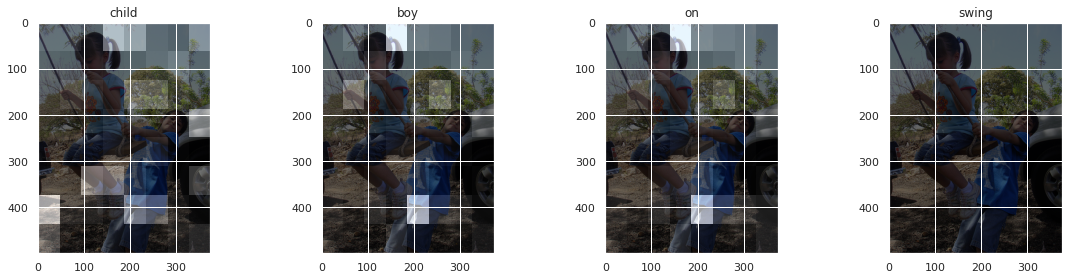

time took to Predict: 1 sec


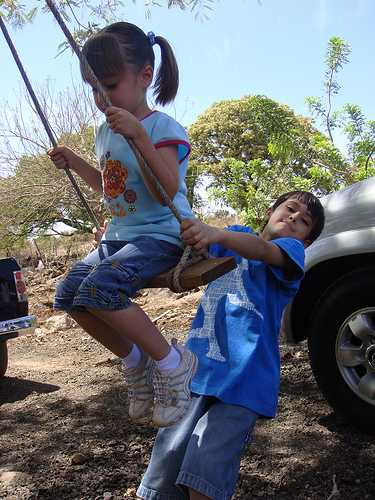

In [108]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)

get_caption(image)

/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/3136688093_568b053bdf.jpg
result_final person is watching behind them
candidate ['person', 'is', 'watching', 'behind', 'them']
BELU score: 0
Real Caption:  performer on concert stage 
Prediction Caption: person is watching behind them


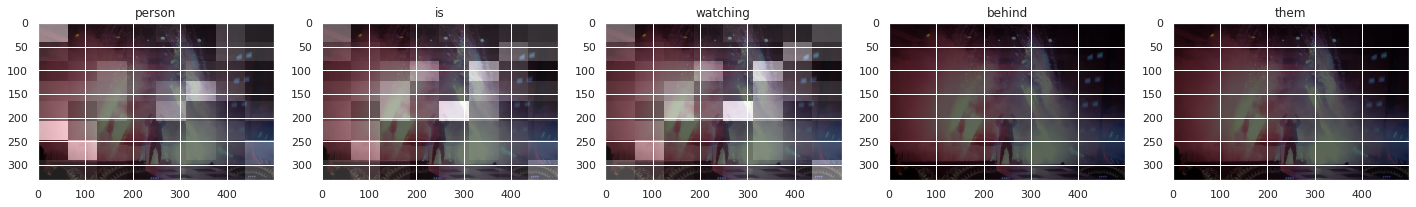

time took to Predict: 1 sec


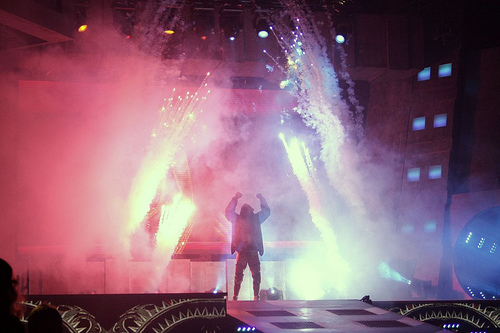

In [109]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)

get_caption(image)

/ssd_scratch/cvit/starc52/Flickr-8K/Flickr-8K/Flicker8k_Dataset/3268191118_ba25fabab6.jpg
result_final bicyclist in beanie doing bike at in midair
candidate ['bicyclist', 'in', 'beanie', 'doing', 'bike', 'at', 'in', 'midair']
BELU score: 0
Real Caption:  bmx rider makes jump 
Prediction Caption: bicyclist in beanie doing bike at in midair


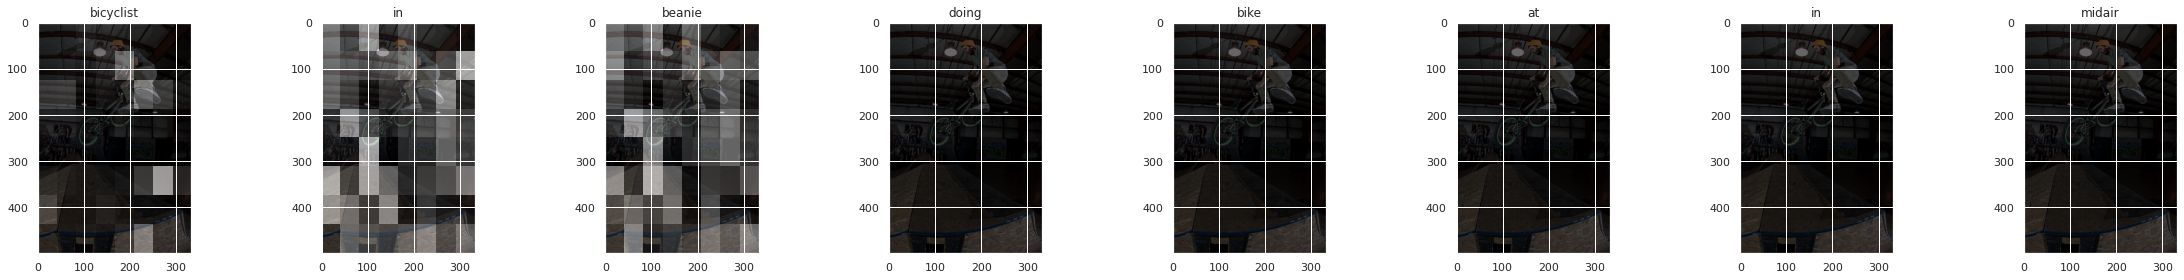

time took to Predict: 2 sec


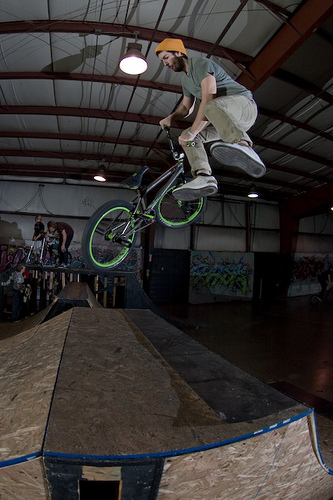

In [110]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)

get_caption(image)